# Building an Inverse Image Search Service

Leveraging the power of transfer learning can be very useful in many applications. Particularly, in this notebook we'll harness the readiness of pre-trained network to build an inverse image search engine or, more clearly, a "search by example" service.

Of course, all deep learning tasks begin with data acquisition, so this will be no different. 

The images we will use will be a subset of Imagenet and then passed through a pre-trained network to compile a "embedding" dictionary that'll later on will allow us to fetch similar images using a simple nearest neighbor search.

## Prerequisites

Let's import the libraries we'll need.

In [1]:
%matplotlib inline

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import random
import os
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
from PIL import Image
from IPython.display import HTML, Image as IPImage, display
import numpy as np
import glob
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


## Using Images from Imagenet

Imagenet is an enormous corpus of Images that span among many thousands of classes. Of course, training a network from scratch on a dataset this big is a titanic endeavor. That's why most of the pretrained models we use in Keras have been trained on Imagenet already, probably for lots and epochs and with lots of computational power.

Imagenet alone is around 100GB big. However, we can workaround this volume constraint by using a subset of it. In this project, we use a dataset called [Tiny ImageNet](https://tiny-imagenet.herokuapp.com/), which, as it name suggests, is a way smaller version of the well known dataset. 

It is comprissed of 200 classes, where each has 500 training images, 50 validation images and 50 images. 

However, our goal is to use these images to create an embedding space that we'll use as the neighborhood to support our inverse image search engine. That's why we don't mind using all of the images, independently of their original intent.

We define the source folder of the Tiny ImageNet dataset in `TINY_IMAGENET_SOURCE`.

In [2]:
TINY_IMAGENET_SOURCE = 'C:\\Users\\Jesús\\Desktop\\ninkle-datasets-tiny-imagenet-200-1'
# IMAGENET_URLS_LOCATION = '/floyd/input/imagenet_urls/fall11_urls.txt'

Images in `val` and `test` subfolders are inside a directory called `images`. Images inside `training` are stored in a directory called `images` inside another subfolder named after the ID of the class they belong to. Hence, in order to load them all into memory, we need to take this into account. 

Let's write a function to do the heavy-lifting for us.

In [3]:
def load_subset(source, size=10000):
    validation_pattern = os.path.join(source, 'val', 'images', '*')
    test_pattern = os.path.join(source, 'test', 'images', '*')
    train_pattern = os.path.join(source, 'train', '*', 'images', '*')
    
    all_source_images_paths = glob.glob(validation_pattern) + glob.glob(test_pattern) + glob.glob(train_pattern)
    sample_images_paths = random.sample(all_source_images_paths, size)
    
    images = []
    for picture in sample_images_paths:
        try:
            i = mpimg.imread(picture)
            
            # Only keep those images with three dimensions.
            if len(i.shape) == 3:
                images.append(i)
        
        except Exception as e:
            print(f'Could not load image {picture}. Reason: {e}')

    return images

images = load_subset(TINY_IMAGENET_SOURCE, size=20000)
print(f'Loaded {len(images)} images.')

Loaded 19625 images.


Now that we loaded a couple of images, let's see one of them.

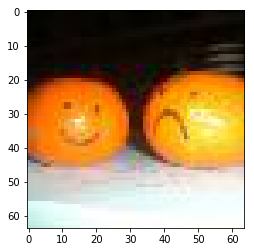

In [4]:
SAMPLE_INDEX = 0  # Change to see another image.

assert 0 <= SAMPLE_INDEX < len(images)

plt.imshow(images[SAMPLE_INDEX])

It seems we're good to go. Let's move on!

## Projecting Images into an N-Dimensional Space

Given the set of images we gathered in the last step, we can organize them such that similar images are near each other in the vectorial space produced by the last-but-one layer of a pre-trained network. In other words, treat the weights of these layer as _image embeddings_.

Let's start by loading a pre-trained model.

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, None, None, 2 0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, None, None, 6 192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, None, None, 6 192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, None, None, 6 192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 9 288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, None, None, 6 192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, None, None, 6 0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, None, None, 1 384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, None, None, 1 0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, None, None, 1 0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, None, None, 7 0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 1 147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 1 576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 1 576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, None, None, 1 576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, None, None, 1 0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, None, None, 1 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, None, None, 7 0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, None, 1 147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, None, None, 1 576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, None, None, 1 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 1 258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, None, None, 1 576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, None, None, 3 0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, None, None, 1 576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, None, None, 3 0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, None, None, 7 0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 7 0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
predictions (Dense)             (None, 1000)         2049000     avg_pool[0][0]                   
Total params: 23,851,784
Trainable params: 23,817,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


Our target layer is `avg_pool`, which produces outputs of 2048 elements. This will be the dimension of our image embeddings:

In [6]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

Good. Let's create a model that given an image, return its vectorial representation:

In [7]:
def get_vector(model, img):
    if not isinstance(img, list):
        images = [img]
    else:
        images = img
        
    target_size = (299, 299)  # Default for ImagenetV3
    images = [cv2.resize(i, target_size) for i in images]

    pre_processed_images = preprocess_input(np.asarray(images))
    
    return model.predict(pre_processed_images)

processed_batch = get_vector(model, images[:10])
print(f'Processed batch shape: {processed_batch.shape}')

Processed batch shape: (10, 2048)


In order to not abuse of our RAM, let's process our dataset in chunks. If your RAM can take it, increase the `CHUNK_SIZE` or even process the whole dataset at once!

In [ ]:
CHUNK_SIZE = 512

processed_chunks = []
for chunk_index in range(0, len(images), CHUNK_SIZE):
    chunk = images[chunk_index:(chunk_index + CHUNK_SIZE)]
    processed_chunk = get_vector(model, chunk)
    
    processed_chunks.append(processed_chunk)
    
    print(f'Processed {chunk_index + CHUNK_SIZE} images of {len(images)}')
    
vectors = np.concatenate(processed_chunks)

## Finding Nearest Neighbors in High-Dimensional Spaces

Now that all images in the dataset have been projected into a 2408D space, we can build a `k-Nearest Neighbors` model on it to then fetch the most similar images (i.e., neighbors) in this space.

In [ ]:
NUMBER_OF_NEIGHBORS = 10
n_neighbors = NearestNeighbors(n_neighbors=NUMBER_OF_NEIGHBORS, algorithm='ball_tree')
neighbors = n_neighbors.fit(vectors)

Let's see what are the neighbors of our always reliable Pug image. For that matter, we will use the following function

In [ ]:
def get_and_plot_neighbors(model, neighbors, images, image_path):
    pug_image = mpimg.imread(image_path)
    pug_vector = get_vector(model, pug_image)

    distances, indices = neighbors.kneighbors(pug_vector)


    plt.figure(figsize=(20,10))
    columns = 5

    for i, (index, distance) in enumerate(zip(indices[0], distances[0])):
        plt.subplot(len(distances[0]) / columns + 1, columns, i + 1)
        plt.title(f'Distance: {distance}')
        plt.imshow(images[index])

In [ ]:
get_and_plot_neighbors(model, neighbors, images, 'data/pug.jpeg')

That's impressive. Not only the two closest neighbors are dogs, but Pugs! We also see another images related with things that are CLEARLY not a Pug, such as a purple car!

Let's try now with a car:

In [ ]:
get_and_plot_neighbors(model, neighbors, images, 'data/tesla.jpg')

It seems our image search engine recognizes the **car** concept pretty well. 

Let's try with an image of a guitar:

In [ ]:
get_and_plot_neighbors(model, neighbors, images, 'data/guitar.jpg')

This is interesting. None of the neighbouring images correspond to a guitar. What's more closely related is the 9th neighbor, which is an iPod. This might be a consequence of insufficient data in our dataset, or just the **guitar** category is not present in the Tiny ImageNet corpus of images. 